                Close  Close_Next   volume       Open       High        Low
Date                                                                       
2015-08-05  20.559999   18.600000   692700  21.000000  21.360001  20.129999
2015-08-06  18.600000   19.299999   326700  20.500000  20.650000  17.283001
2015-08-07  19.299999   19.010000   598900  18.340000  19.580000  17.670000
2015-08-10  19.010000   19.559999   259100  19.430000  19.690001  18.820000
2015-08-11  19.559999   19.370001   741500  18.790001  19.940001  18.790001
2015-08-12  19.370001   20.600000   452700  19.469999  19.500000  18.690001
2015-08-13  20.600000   20.330000   491700  19.799999  20.780001  19.379999
2015-08-14  20.330000   21.070000   526600  19.950001  20.889999  19.219999
2015-08-17  21.070000   21.440001   562600  19.930000  21.705000  19.930000
2015-08-18  21.440001   21.389999   380000  21.280001  21.580000  21.100000
2015-08-19  21.389999   21.200001   299700  21.080000  21.809999  20.309999
2015-08-20  

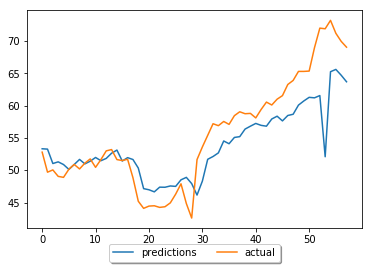

In [2]:
# -*- coding: utf-8 -*-
 
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
 
 
fname="C:\\Users\\pengl\\Dropbox\\Data science\\lite.csv"
data_csv = pd.read_csv (fname, header = 0, index_col = 0, usecols = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'] )
 
#how many data we will use 
# (should not be more than dataset length )
data_to_use= 660
 
# number of training data
# should be less than data_to_use
train_end =600
 
 
total_data=len(data_csv)
 
#most recent data is in the end 
#so need offset
start=total_data - data_to_use
 
 
#currently doing prediction only for 1 step ahead
steps_to_predict =1
 
  
# ydate = data_csv.iloc [start:total_data ,0] #Date
yt = data_csv.iloc [start:total_data ,3]    #Close price
yt1 = data_csv.iloc [start:total_data ,0]   #Open
yt2 = data_csv.iloc [start:total_data ,1]   #High
yt3 = data_csv.iloc [start:total_data ,2]   #Low
vt = data_csv.iloc [start:total_data ,4]    #volume
 
 
yt_ = yt.shift (-1)
     
data = pd.concat ([yt, yt_, vt, yt1, yt2, yt3], axis =1)
data.columns = ['Close', 'Close_Next', 'volume', 'Open', 'High', 'Low']
     
data = data.dropna()
     
print (data)


# target variable - closed price
# after shifting
y = data ['Close_Next']

        
# closed, volume, open, high, low    
cols =['Close', 'volume', 'Open', 'High', 'Low']
x = data [cols]

# Rescale (normalize) data as below. 
# Here feature_range is tuple (min, max), default=(0, 1) is desired range of transformed data 
scaler_x = preprocessing.MinMaxScaler ( feature_range =( -1, 1))
x = np. array (x).reshape ((len( x) ,len(cols)))
x = scaler_x.fit_transform (x)
    
scaler_y = preprocessing. MinMaxScaler ( feature_range =( -1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)   


# Divide data into training and testing set.
x_train = x [0: train_end,]
x_test = x[ train_end +1:len(x),]    
y_train = y [0: train_end] 
y_test = y[ train_end +1:len(y)]  
x_train = x_train.reshape (x_train. shape + (1,)) 
x_test = x_test.reshape (x_test. shape + (1,))


# Building and Running LSTM
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
 
 
seed =2017
np.random.seed (seed)
fit1 = Sequential ()
fit1.add (LSTM(1000, activation="tanh", input_shape=(5, 1), recurrent_activation="hard_sigmoid"))
fit1.add (Dropout(0.2))
fit1.add (Dense(activation="linear", units=1))
 
fit1.compile (loss ="mean_squared_error" , optimizer = "adam")   
fit1.fit (x_train, y_train, batch_size =1, epochs =25, shuffle = False)
 
print (fit1.summary())
 
score_train = fit1.evaluate (x_train, y_train, batch_size =1)
score_test = fit1.evaluate (x_test, y_test, batch_size =1)
print (" in train MSE = ", round( score_train ,4)) 
print (" in test MSE = ", round(score_test),6)
 
    
pred1 = fit1.predict (x_test) 
pred1 = scaler_y.inverse_transform (np. array (pred1). reshape ((len( pred1), 1)))
     
prediction_data = pred1[-1]     

fit1.summary()
print ("Inputs: {}".format(fit1.input_shape))
print ("Outputs: {}".format(fit1.output_shape))
print ("Actual input: {}".format(x_test.shape))
print ("Actual output: {}".format(y_test.shape))
   
 
print ("prediction data:")
print (prediction_data)
 
 
#print ("actual data")
#x_test = scaler_x.inverse_transform (np. array (x_test). reshape ((len( x_test), len(cols))))
#print (x_test)
 
 
plt.plot(pred1, label="predictions")
 
 
y_test = scaler_y.inverse_transform (np. array (y_test). reshape ((len( y_test), 1)))
plt.plot( [row[0] for row in y_test], label="actual")
 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=2)
 
#import matplotlib.ticker as mtick
#fmt = '$%.0f'
#tick = mtick.FormatStrFormatter(fmt)
 
#ax = plt.axes()
#ax.yaxis.set_major_formatter(tick)
 
 
plt.show()
